# Data Exploration

Bertrand Thia (bt2513)

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from keras.preprocessing.image import ImageDataGenerator
import os

Using TensorFlow backend.


# Reading the training data

### Importing the data

In [2]:
train_labels = pd.read_csv('./train.csv')
train_labels.head()

,id,filename,label
0,0,train/img-0.jpeg,normal
1,1,train/img-1.jpeg,viral
2,2,train/img-2.jpeg,viral
3,3,train/img-3.jpeg,bacterial
4,4,train/img-4.jpeg,viral


In [3]:
print('Size of the training set:', train_labels.shape[0])

Size of the training set: 1127


In [4]:
# Checking the distribution of the labels

train_labels['label'].value_counts()

normal       350
bacterial    350
viral        350
covid         77
Name: label, dtype: int64

We can observe that our dataset is pretty imbalanced, and we will need to address this issue later. Possible solutions can be class weigthing and/or the use of sampling techniques.

This .csv file allows us to connect the chest X-rays images to their label. Let's combine everything in one table for the visualization.

### Combining the images and their label in one table for visualization

Let's create a table containing the `id`, `pix_value` and `label` of each chest X-rays at hand.

In [5]:
n_rows = train_labels.shape[0]
img_list = [np.array(Image.open('./train/' + train_labels.loc[i, 'filename'])) for i in range(n_rows)]
X = train_labels.drop(columns= ['filename'])
X['pix_value'] = img_list
X = X[['id', 'pix_value', 'label']]
#X.head()

In [6]:
# Checking the information of the first image

img = Image.open('./train/' + train_labels.loc[0, 'filename'])
print(img.format)
print(img.mode)
print(img.size)

JPEG
L
(1120, 965)


### Visualizing some chest X-rays images

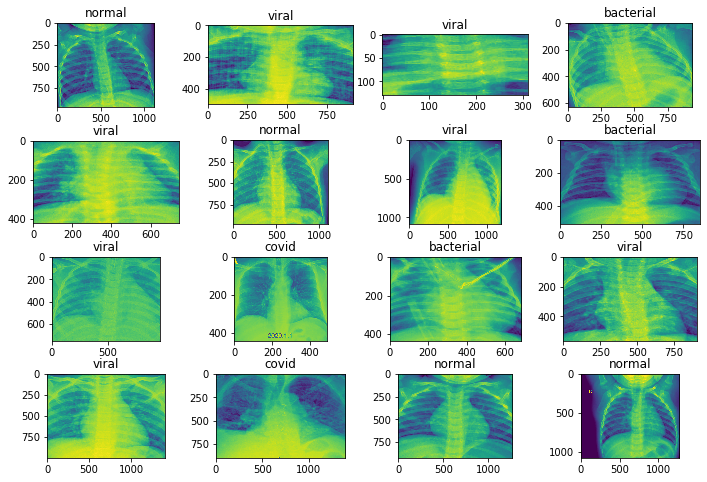

In [7]:
# Visualizing the first 16 chest X-rays images and their labels

fig, axs = plt.subplots(4, 4, figsize= (12, 8))
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].imshow(X.loc[i, 'pix_value'])
    axs[i].set_title(X.loc[i, 'label'])
plt.subplots_adjust(hspace= 0.4)

Overall, there is no clear difference between the x-ray images of the different cases (bacterial, viral, normal and covid). Also, the data looks quite heterogeneous in terms of size and qualities.

# Data Preprocessing

Given that the images are of different sizes and qualities, let's preprocess the data to improve uniformity. We are going to use some small preprocessing techniques here and standardize our data later.

### Resizing our images 

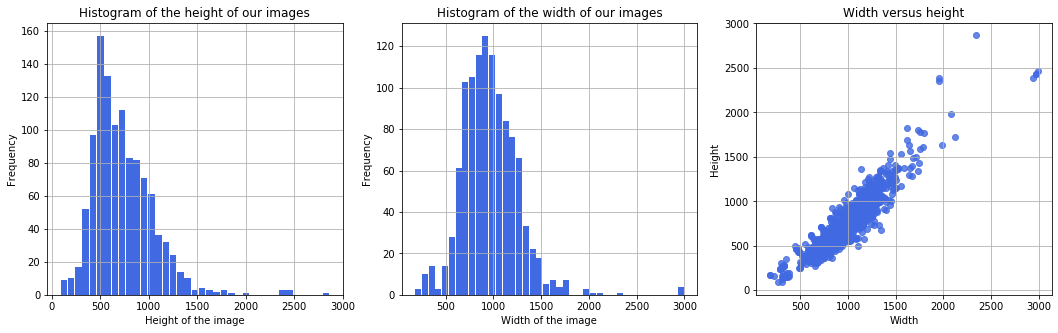

In [8]:
# Checking the distribution of the height and width of our images

H = []
W = []

for k in range(X.shape[0]):
    shape = X.loc[k, 'pix_value'].shape
    H.append(shape[0])
    W.append(shape[1])
    
fig, axs = plt.subplots(1, 3, figsize= (18, 5))
axs[0].hist(H, bins= 'auto', rwidth=0.9, color= 'royalblue')
axs[0].set_title('Histogram of the height of our images')
axs[0].set_xlabel('Height of the image')
axs[0].set_ylabel('Frequency')
axs[0].grid()
axs[1].hist(W, bins= 'auto', rwidth=0.9, color= 'royalblue')
axs[1].set_title('Histogram of the width of our images')
axs[1].set_xlabel('Width of the image')
axs[1].set_ylabel('Frequency')
axs[1].grid()
axs[2].scatter(W, H, c= 'royalblue', marker= 'o', alpha= 0.8)
axs[2].set_title('Width versus height')
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Height')
axs[2].grid()

The relationship between the width and the height of the images in our dataset is quite linear. We can expect that resizing our data won't distort them too much in an heterogeneous way, but uniformly. We will use the median dimension of our images as a point of reference in our study:

In [9]:
# Defining the shape of the resizing

new_W = int(np.median(W))
new_H = int(H[W.index(np.median(W))])
print('Resizing:', (new_H, new_W))

Resizing: (755, 936)


In [10]:
# Resizing our dataset

resized_pix_list = []
for k in range(X.shape[0]):
    dim = (new_H, new_W)
    resized_pix_list.append(cv2.resize(X.loc[k, 'pix_value'], dim))
X = X.assign(resized_pix = resized_pix_list)

Here are the images' look, after the resizing:

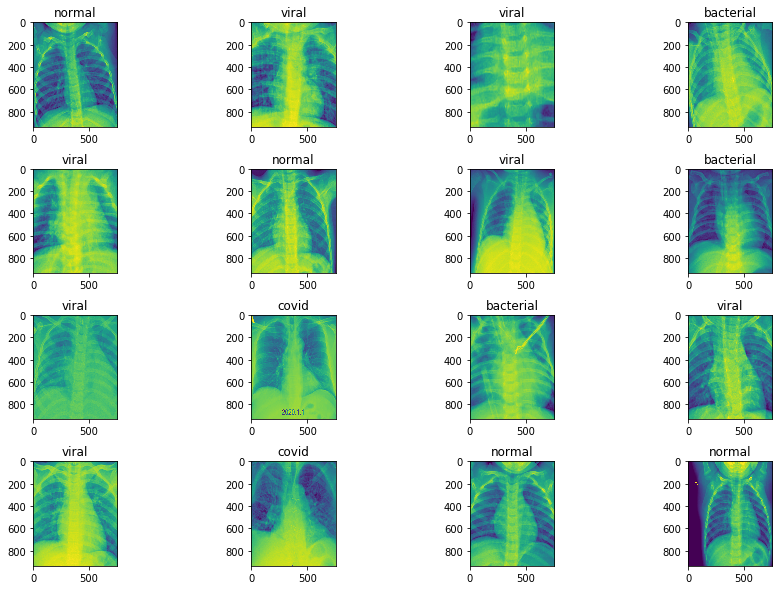

In [14]:
# Displaying the 16 first resized img

fig, axs = plt.subplots(4, 4, figsize= (15, 10))
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].imshow(X.loc[i, 'resized_pix'])
    axs[i].set_title(X.loc[i, 'label'])
plt.subplots_adjust(hspace= 0.4)

### Denoising the images

In this section, we are going to use a gaussian smooth to remove potential unwanted noise in our data. We will later compare if our model performs better with this treatment.

In [15]:
blurred_pix_list = []
for k in range(X.shape[0]):
    blurred_pix_list.append(cv2.GaussianBlur(X.loc[k, 'resized_pix'], (5, 5), 0))
X = X.assign(blurred_pix = blurred_pix_list)

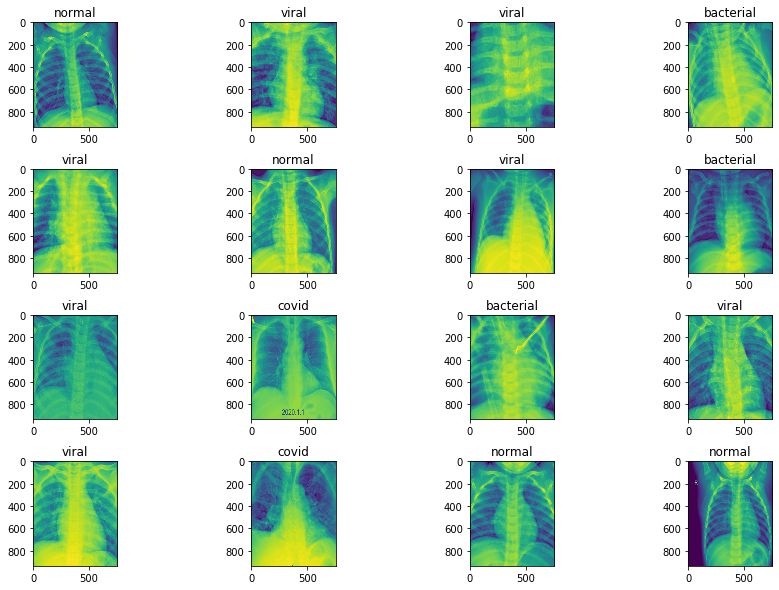

In [16]:
# Displaying the 16 first blurred img

fig, axs = plt.subplots(4, 4, figsize= (15, 10))
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].imshow(X.loc[i, 'blurred_pix'])
    axs[i].set_title(X.loc[i, 'label'])
plt.subplots_adjust(hspace= 0.4)

The effects of the blurring are not clear for all of the images displayed, but we can notice a difference for the 9th image. We can expect similar results on other images and we will assess the relevancy of this treatment later.

**We will use these preprocessing techniques during our study in the next notebooks.** 

---

# Appendix

### Saving the denoised images for later

In [18]:
from keras.preprocessing import image

In [27]:
# Denoising the training images and saving them for later use

n_rows = train_labels.shape[0]
path = './train2/train/'

for i in range(n_rows):
    image_path = './train/' + train_labels.iloc[i, 1]
    img = image.load_img(image_path, color_mode= 'grayscale')
    denoised_img = cv2.GaussianBlur(np.array(img), (5, 5), 0)
    name = train_labels.loc[i, 'filename'].split('/')[1]
    cv2.imwrite(path + name, denoised_img)

In [28]:
# Repeating the same procedure for the test set
test_data = pd.read_csv('./test.csv')
n_rows = test_data.shape[0]
path = './test2/test/'

for i in range(n_rows):
    image_path = './test/' + test_data.iloc[i, 1]
    img = image.load_img(image_path, color_mode= 'grayscale')
    denoised_img = cv2.GaussianBlur(np.array(img), (5, 5), 0)
    name = test_data.loc[i, 'filename'].split('/')[1]
    cv2.imwrite(path + name, denoised_img)

### Data visualization

In [17]:
groupByLabel = X.groupby('label')
examples = groupByLabel.first()

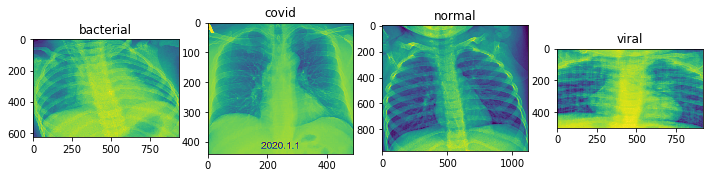

In [18]:
# Visualizing different chest X-rays images wrt their labels

fig, axs = plt.subplots(1, 4, figsize= (12, 8))
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].imshow(examples.iloc[i, 1])
    axs[i].set_title(examples.index[i])
plt.subplots_adjust(hspace= 0.4)

### Effect of the denoising

Text(0.5, 1.0, 'Denoised X-ray image')

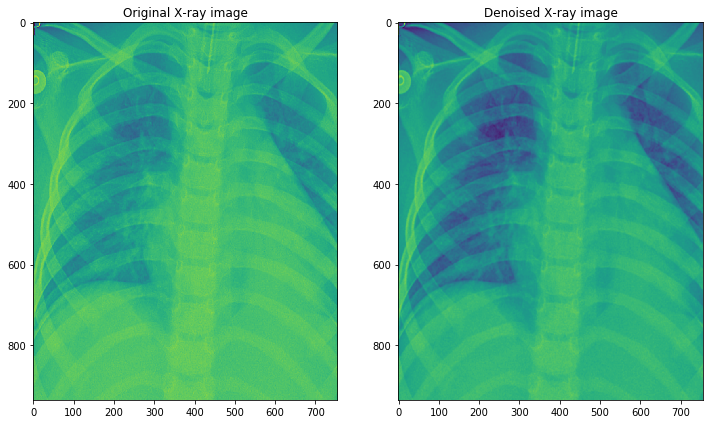

In [19]:
fig, axs = plt.subplots(1, 2, figsize= (12, 8))
axs = axs.ravel()

axs[0].imshow(X.loc[8, 'resized_pix'])
axs[0].set_title('Original X-ray image')
axs[1].imshow(X.loc[8, 'blurred_pix'])
axs[1].set_title('Denoised X-ray image')